In [1]:
import numpy as np
import pandas as pd
import sklearn as ktl
import pickle
import matplotlib.pylab as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [2]:
sdg_indexes = pd.read_csv("data/sdg_prediction/sdg_indexes.csv")
sat_mod = pd.read_csv("data/sdg_prediction/sat_mod.csv")
sdg_indicators = pd.read_csv("data/sdg_prediction/sdg_indicators_norm.csv")

## Setting up model 

In [3]:
sat_mod.columns

Index(['Unnamed: 0', 'id', 'lnEGDPpc2012', 'lnagr_land2012', 'lnurb_land2012',
       'ln_perUrb_land2012', 'ln_tr400_pop2012', 'ln_pm25_2012',
       'ln_land_temp2012', 'ln_t400NTLpc2012', 'ln_dist_road2017',
       'ln_ghsl2015', 'dist_diamond2015', 'ln_mal_inci_rt_mean',
       'ln_dist_water2017mean', 'ln_elev2017mean', 'ln_dist_drug2017mean'],
      dtype='object')

In [4]:
#X = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land2012',  "ln_pm25_2012", "ln_land_temp2012"]]
X = sat_mod[['ln_t400NTLpc2012', 'lnagr_land2012', 'lnurb_land2012','ln_land_temp2012','ln_tr400_pop2012','ln_dist_road2017','ln_ghsl2015', 
             "ln_dist_water2017mean",'ln_dist_drug2017mean', 'ln_elev2017mean', 'ln_pm25_2012']]
  #'dist_diamond2015', 
    # Elevation has a huge impact on 2 and 13 
y = sdg_indexes["imds"]

np.random.seed(42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = linear_model.Ridge()
model.fit(X_train, y_train);

print(model.score(X_test, y_test))

coeff = model.coef_
print("positive:")
print(np.array(X.columns)[coeff>2])
print("negative:")
print(np.array(X.columns)[coeff<-2])
print(model.coef_)


0.67569599438779
positive:
['lnurb_land2012' 'ln_ghsl2015']
negative:
['ln_tr400_pop2012' 'ln_elev2017mean' 'ln_pm25_2012']
[ 0.86020136  1.28777272  5.71602041 -1.8779711  -4.01675819 -1.17348359
  3.97961299  0.12663587 -1.53869912 -2.66044248 -6.7697645 ]


## Test for all labels 

In [5]:
ridge_results = pd.DataFrame(columns=["Feature", "r2", "MAE"])
ri_predict = pd.DataFrame()

In [6]:
y_variables = sdg_indexes[['index_sdg1', 'index_sdg2', 'index_sdg3', 'index_sdg4',
       'index_sdg5', 'index_sdg6', 'index_sdg7', 'index_sdg8', 'index_sdg9',
       'index_sdg10', 'index_sdg11', 'index_sdg13', 'index_sdg15',
       'index_sdg16', 'index_sdg17', 'imds']]

#y_variables = sdg_indicators.drop(columns = {"id"})

In [7]:
#x = sat_mod[[ "ln_t400NTLpc2012", "ln_tr400_pop2012", 'lnEGDPpc2012', 'ln_perUrb_land2012',  "ln_pm25_2012", "ln_land_temp2012",'ln_dist_road2017' ,'ln_ghsl2015']]
# This ones make some sdg more relevant 
#
x = X

for y_variable in y_variables:
    
    y = y_variables[y_variable]

    np.random.seed(42)
    x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2) 

    ridge_model = linear_model.Ridge()

    r2 = np.mean(cross_val_score(ridge_model, x, y, scoring="r2"))
    mae = np.mean(cross_val_score(ridge_model, x, y, scoring="neg_mean_absolute_error"))
    
    ridge_results.loc[len(ridge_results.index)] = [y_variable, r2, mae]

    # Prediction df 
    ridge_model.fit(x_train,y_train)
    y_pred = ridge_model.predict(x_test)

    col0 = y_variable + "_true"
    col1 = y_variable + "_pred"
    temp_predict = pd.DataFrame({col0: y_test, col1: y_pred}, index=y_test.index)
    temp_predict.index.name = "id"
    
    if ri_predict.empty:
        ri_predict = temp_predict
    else:
        ri_predict = ri_predict.merge(temp_predict, on="id", how="outer")

In [8]:
ridge_results[ridge_results["r2"]>0.9].round(2)

,Feature,r2,MAE


In [9]:
ridge_results[ridge_results["r2"]>0.8].round(2)

,Feature,r2,MAE


In [10]:
ridge_results[(ridge_results["r2"]>=0.7) & (ridge_results["r2"]<0.8)].round(4)

,Feature,r2,MAE
21,sdg4_6_pnl_abs,0.7078,-0.296


In [15]:
ridge_results[(ridge_results["r2"]>=0.6) & (ridge_results["r2"]<0.7)].round(4)

,Feature,r2,MAE
3,sdg1_1_pubn_abs,0.6533,-0.2215
18,sdg4_1_mhs_abs,0.6775,-0.1842
19,sdg4_1_fhs_abs,0.6341,-0.2089
29,sdg7_3_tee_abs,0.6513,-0.1839
31,sdg8_5_ompr_abs,0.6598,-0.1577
32,sdg8_5_ofpr_abs,0.6663,-0.1581
33,sdg8_6_mlm_abs,0.6027,-0.1752


In [16]:
ridge_results[(ridge_results["r2"]>=0.5) & (ridge_results["r2"]<0.6)].round(4)

,Feature,r2,MAE
1,sdg1_4_abs,0.5525,-0.4952
6,sdg2_2_cm_abs,0.5911,-0.2304
34,sdg8_6_wlm_abs,0.5551,-0.1883
39,sdg9_c_hf_abs,0.5657,-0.2742
41,sdg10_2_dss_abs,0.5506,-0.3701
42,sdg11_1_ho_abs,0.5061,-0.2015
50,sdg16_6_aob_abs,0.5759,-0.1709
52,sdg17_5_tpi_abs,0.5770,-0.1915


In [12]:
ridge_results[ridge_results["r2"]<0 ].round(4)

,Feature,r2,MAE
1,sdg1_4_abs,0.5525,-0.4952
2,sdg1_1_dtl_abs,0.3197,-0.2555
3,sdg1_1_pubn_abs,0.6533,-0.2215
4,sdg1_2_dd_abs,0.4795,-0.4333
5,sdg1_4_ebs_abs,0.4244,-0.3047
6,sdg2_2_cm_abs,0.5911,-0.2304
7,sdg2_2_wow_abs,0.4705,-0.1954
10,sdg3_2_fb_abs,0.4329,-0.2072
11,sdg3_2_ffb_abs,0.4099,-0.2102
17,sdg3_7_bpw_abs,0.4629,-0.2253


In [13]:
ridge_results[ridge_results["r2"]<0].round(4)

,Feature,r2,MAE
0,Unnamed: 0,-36.5849,-100.0020
8,sdg2_4_apu_abs,-0.6842,-0.4947
9,sdg2_4_tm_abs,-1.6597,-0.4599
12,sdg3_3_cd_abs,-14.0677,-0.3114
13,sdg3_3_pd_abs,-10.7214,-0.2717
14,sdg3_3_mc_abs,-138.7141,-0.3049
15,sdg3_3_tc_abs,-0.2770,-0.2455
16,sdg3_3_vih_abs,-0.0724,-0.2130
22,sdg4_c_uti_abs,-0.0042,-0.2233
24,sdg6_1_wdc_abs,-2.3172,-0.3429


KeyError: 'index_sdg1_true'

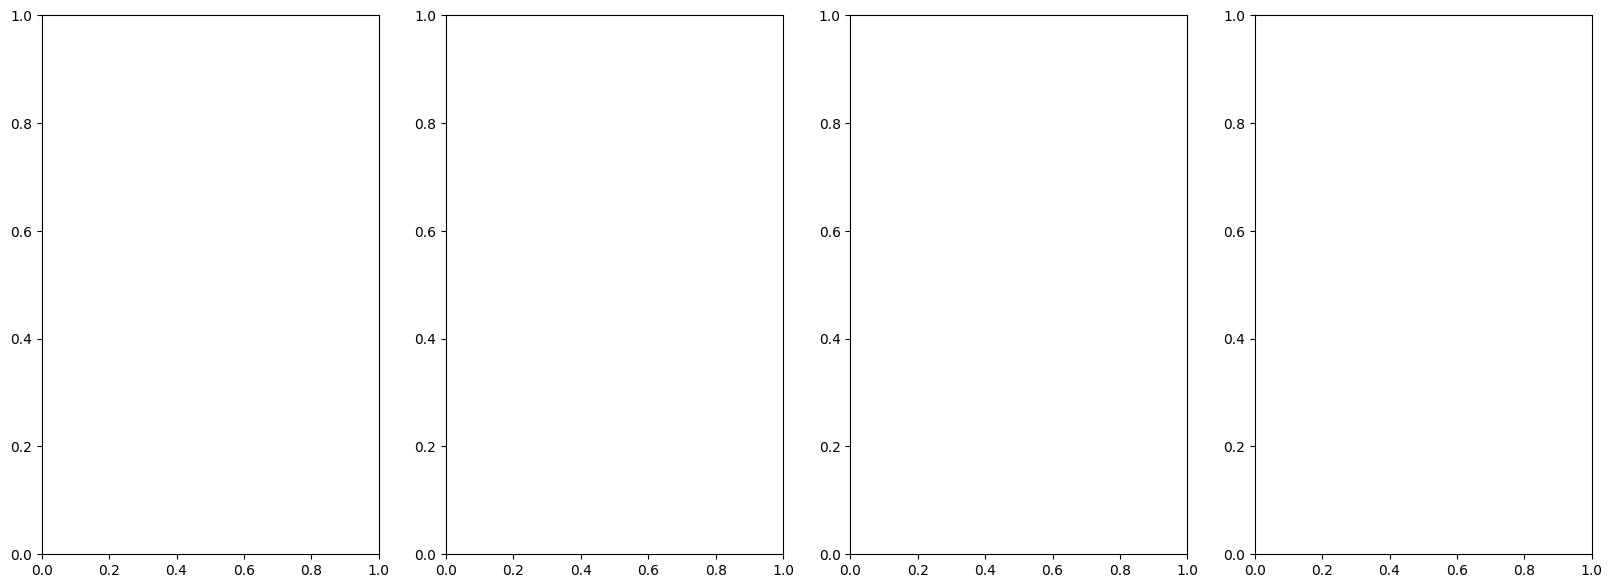

In [14]:
fig, ((ax0, ax1, ax2, ax3)) = plt.subplots(nrows=1, 
                                         ncols=4, 
                                         figsize=(20, 7))

# Graph 1 
g_x = ri_predict["index_sdg1_true"]
g_y = ri_predict["index_sdg1_pred"]

ax0.scatter(x = g_x, y = g_y)
ax0.set(xlabel="sdg1_1_pubn_abs_true", ylabel="sdg1_1_pubn_abs_pred", title="SDG1")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax0.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg7_true"]
g_y = ri_predict["index_sdg7_pred"]

ax1.scatter(x = g_x, y = g_y)
ax1.set(xlabel="sdg9_c_hf_abs_true", ylabel="sdg9_c_hf_abs_pred", title="index_sdg7")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax1.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg11_true"]
g_y = ri_predict["index_sdg11_pred"]

ax2.scatter(x = g_x, y = g_y)
ax2.set(xlabel="sdg1_1_dtl_abs_true", ylabel="sdg1_1_dtl_abs_pred", title="index_sdg11")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax2.plot(g_x,p(g_x),"r-")


# Graph 1 
g_x = ri_predict["index_sdg9_true"]
g_y = ri_predict["index_sdg9_pred"]

ax3.scatter(x = g_x, y = g_y)
ax3.set(xlabel="sdg3_2_fb_abs_true", ylabel="sdg3_2_fb_abs_pred", title="index_sdg9")

# add trendline
z = np.polyfit(g_x, g_y, 1)
p = np.poly1d(z)
ax3.plot(g_x,p(g_x),"r-")

# Adjust Hyperparameters

In [ ]:
model.get_params()

In [ ]:
model_tuned = linear_model.Ridge(alpha=0.0001, max_iter=1000)
model_tuned.fit(X_train, y_train);
model.score(X_test, y_test)


In [ ]:
alpha_space = np.logspace(-4,0,30)
alpha_space

ridge_scores = []
ridge_pipeline = make_pipeline(StandardScaler(), Ridge())

for alpha in alpha_space: 
    ridge_pipeline.alpha = alpha
    val = np.mean(cross_val_score(ridge_pipeline, X, y, cv = 10))
    ridge_scores.append(val)

In [ ]:
plt.figure(figsize=(8,8))
plt.plot(alpha_space, ridge_scores, marker="D", label = "ridge")
plt.legend()
plt.show()

In [ ]:
def evaluate_preds(model, y_true, y_preds):
    """
    Performs evaluation comparison on y_true labels vs. y_pred labels
    on a classification.
    """
    r2 = np.mean(cross_val_score(model, X, y, scoring="r2"))
    mae = np.mean(cross_val_score(model, X, y, scoring="neg_mean_absolute_error"))
    metric_dict = {"R2": round(r2, 2),
                   "MAE": round(mae, 2)}
    print(f"R2: {r2 * 100:.2f}%")
    print(f"MAE: {mae:.2f}")
    
    return metric_dict

In [ ]:
grid = {"alpha": alpha_space,
        "copy_X": [True, False],
        "max_iter": [None, 10, 100, 200, 500, 1000, 10000], 
        "solver": ["auto", "svd", "cholesky", "lsqr", "sparse_cg"]}

np.random.seed(42)
rs_rid_model= RandomizedSearchCV(estimator = model,
                                 param_distributions=grid,
                                 n_iter=100,
                                 cv=5,
                                 verbose=0)

rs_rid_model.fit(X_train, y_train);

In [ ]:
rs_rid_model.best_params_

In [ ]:
# Uses the best model for the prediction
rs_y_preds = rs_rid_model.predict(X_test)

rs_metrics = evaluate_preds(rs_rid_model, X, y)